In [2]:
import numpy as np
import tensorflow as tf
import cv2
import requests
import os
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import gc


In [3]:
# Utilizando webscrapping en Unplash, descargamos una galería de imágenes de archivo de un 
# objeto determinado.

def descarga_imagen(imagen):
    # Access Key de Unsplash
    ACCESS_KEY = "0byE1o41WexZQJRM5Gy0N2NQIw36GLyZY6XcrUyf_M8"

    # Carpeta donde guardar las imágenes
    output_folder = f"./imagenes/{imagen}"
    os.makedirs(output_folder, exist_ok=True)

    # Palabra clave para buscar imágenes
    query = imagen  # Cambia esto por lo que necesites

    # Número total de imágenes deseadas
    total_images = 100 
    per_page = 30  # Máximo 30 imágenes por solicitud
    num_pages = (total_images // per_page) + 1  # Número de páginas necesarias

    # Descargar imágenes de varias páginas
    img_count = 0
    for page in range(1, num_pages + 1):  # Hacer solicitudes desde page=1 hasta page=num_pages
        print(f"🔍 Descargando página {page}...")

        # URL de la API con paginación
        url = f"https://api.unsplash.com/search/photos?query={query}&per_page={per_page}&page={page}&client_id={ACCESS_KEY}"

        # Hacer la solicitud a la API
        response = requests.get(url)

        # Intentar convertir la respuesta a JSON
        try:
            data = response.json()
        except Exception as e:
            print("Error al convertir la respuesta a JSON:", e)
            print("Respuesta de la API:", response.text)
            exit()

        # Verificar si "results" está en la respuesta
        if "results" not in data:
            print("ERROR: La API no devolvió 'results'. Esto es lo que devolvió:")
            print(data)  # Mostrar la respuesta completa para ver qué está pasando
            exit()

        # Si todo está bien, continuar con la descarga
        for img in data["results"]:
            if img_count >= total_images:
                print("Descarga completada.")
                break  # Detener si ya descargamos suficientes imágenes

            img_url = img["urls"]["full"]  # URL de la imagen en alta calidad
            img_response = requests.get(img_url)

            # Guardar la imagen
            img_path = os.path.join(output_folder, f"{query}_0{img_count}.jpg")
            with open(img_path, "wb") as file:
                file.write(img_response.content)

            #print(f"Imagen descargada: {img_path}")
            img_count += 1
    return


In [4]:
#objetos = ['banana','basketball','book','cup','dog','headphones','airplane','cat','bottle']
#for objeto in objetos: 
#    descarga_imagen(objeto)

In [5]:
#### ENTRENANDO EL MODELO ####



In [6]:
### PREPROCESANDO LAS IMÁGENES CON DATAGENERATOR


def entrenamiento(model_path,n_clases,df,best_val_accuracy):

    # Si es la primera vez que corremos el código, no existe un modelo base pre-entrenado:

    if os.path.exists(model_path):
        print("Cargando el modelo entrenado desde el disco...")
        model = load_model(model_path)
        first_time = False
    else:
        print("Inicializando ResNet50 preentrenado como base...")

        # Inicializar el modelo base ResNet50
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x) # Normalmente entre 0.2 y 0.5. Un dropout muy alto puede dar un modelo infraentrenado.
        # Es el proceso de "apagar" de manera aleatoria un número de neuronas 
        # en una capa durante el entrenamiento de la red neuronal. Esto significa que, en cada 
        # iteración del --entrenamiento--, un % de neuronas se "omiten" al propagar la activación y 
        # también cuando se realiza la retropropagación. Durante la predicción, el Dropout no se aplica.

        predictions = Dense(n_clases, activation='softmax')(x)  # Ajusta a tu número real de clases

        model = Model(inputs=base_model.input, outputs=predictions)
        first_time = True
        # Determina el número de capas a congelar
        num_layers_to_freeze = int(len(base_model.layers) * 0.75)  # Congelar el 75% inferior

        # Congelar capas inferiores
        for layer in base_model.layers[:num_layers_to_freeze]:
            layer.trainable = False

        # Descongelar capas superiores
        for layer in base_model.layers[num_layers_to_freeze:]:
            layer.trainable = True
        # Congelar capas implica establecer layer.trainable = False, evitando que los pesos de estas capas
        # se actualicen durante el entrenamiento. Esta técnica es útil en modelos preentrenados, cuando se
        # desea conservar características aprendidas que ya generalizan eficazmente, especialmente en las 
        # capas inferiores donde se identifican patrones generales como bordes y texturas.
        
        # Se descongelan capas mediante layer.trainable = True, lo que permite al modelo ajustar los pesos 
        # de estas capas para que aprenda características específicas de un conjunto de datos particular. 
        # Normalmente, se congelan las capas inferiores y se descongelan las superiores para captar mejor 
        # las peculiaridades del nuevo dataset.

    if first_time:
        best_val_accuracy = 0.0 
        epocas = 15
        lr = 1e-4 # tasa de aprendizaje
        bs = 32 # tamaño del batch
    else:
        epocas = 5
        lr = 1e-5 # tasa de aprendizaje más pequeña para actualizaciones más suaves
        bs = 32 # ajustar según el rendimiento (tiempo de entrenamiento y memoria utilizada)


    # Compilar el modelo para multiclase
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Directorios de datos
    base_dir = './imagenes'

    # Configuración del aumento de datos con técnicas más agresivas
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=60,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.5, 1.5],  # Ajuste de brillo
    )

    # Generadores para train y validation
    train_generator = datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'train'),
        target_size=(224, 224),  # Redimensionar para asegurar uniformidad
        batch_size=bs,
        class_mode='categorical', # Cambiamos a 'categorical' para multiclase
    )

    validation_generator = datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'validation'),
        target_size=(224, 224),
        batch_size=bs,
        class_mode='categorical' # Cambiamos a 'categorical' para multiclase
    )

    # Añadimos callbacks que ayudan a ajustar la tasa de aprendizaje en función del progreso del entrenamiento
    # y detenerlo anticipadamente si no hay mejoras, respectivamente
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6) ## Qué hace esto
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) ## Qué hace esto

    # Entrenar el modelo

    history = model.fit(
        train_generator,
        epochs=epocas,
        validation_data=validation_generator,
        callbacks=[reduce_lr, early_stop]
    )

    # Si se va a hacer una predicción tras el entrenamiento, es importante hacer un reset:
    validation_generator.reset() 
    # Esto asegura que cuando se hace una predicción, utiliza todas las imágenes desde el 
    # principio, sin saltarse ninguna. Ayuda a mantener todo organizado y consistente.

    # Imprimir la última métrica de cada tipo al finalizar el entrenamiento
    final_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Accuracy final de entrenamiento: {final_accuracy:.4f}")
    print(f"Accuracy final de validación: {final_val_accuracy:.4f}")
    print(f"Loss final de entrenamiento: {final_loss:.4f}")
    print(f"Loss final de validación: {final_val_loss:.4f}")

    # Guardamos los datos de Accuracy y Loss para evaluar las iteraciones:

    # Determina el número de entrenamientos ya hechos
    training_count = len(df) + 1

    # Añadir los nuevos datos al DataFrame
    new_data = pd.DataFrame({
        'training': training_count,
        'final_accuracy': f"{final_accuracy:.4f}",
        'final_val_accuracy': f"{final_val_accuracy:.4f}",
        'final_loss': f"{final_loss:.4f}",
        'final_val_loss': f"{final_val_loss:.4f}",
        'lr': lr
    }, index=[0])

    # Concatenar el nuevo registro al DataFrame existente
    df = pd.concat([df, new_data], ignore_index=True)

    # Guardar el modelo entrenado sólo si la accuracy mejora

    if final_val_accuracy > best_val_accuracy:
        print(f"Mejora detectada en val_accuracy: {final_val_accuracy:.4f} -> guardando modelo.")
        model.save(model_path)
        best_val_accuracy = final_val_accuracy
    else:
        print(f"val_accuracy no ha mejorado: {final_val_accuracy:.4f}")
        print(f"val_accuracy maxima: {best_val_accuracy:.4f}")

    return df, validation_generator, best_val_accuracy

In [7]:
### ENTRENANDO EL MODELO CON IMÁGENES PREPROCESADAS

# Función para preprocesar imágenes:

def preprocess_images(base_dir, subfolder):
    def rotate_image(image):
        angle = tf.random.uniform([], -10, 10, dtype=tf.float32)
        radian = tf.cast(angle, tf.float32) * np.pi / 180.0
        
        c = tf.cos(radian)
        s = tf.sin(radian)

        # Matriz de transformación
        transform = [c, s, 0.0, -s, c, 0.0, 0.0, 0.0]

        # Calcular bounding box de la imagen rotada
        height, width = image.shape[:2]
        new_width = int(abs(width * c.numpy()) + abs(height * s.numpy()))
        new_height = int(abs(width * s.numpy()) + abs(height * c.numpy()))
        
        # Asegúrate de que el padding es positivo
        pad_width = max(0, (new_width - width) // 2)
        pad_height = max(0, (new_height - height) // 2)
        
        # Padding
        image_padded = tf.pad(image, [[pad_height, pad_height], [pad_width, pad_width], [0, 0]], mode='REFLECT')
        
        # Aplicar transformación
        rotated_image = tf.raw_ops.ImageProjectiveTransformV2(
            images=tf.expand_dims(image_padded, 0),
            transforms=tf.convert_to_tensor([transform], dtype=tf.float32),
            output_shape=[height, width],
            fill_mode='CONSTANT',
            interpolation='BILINEAR'
        )[0]

        return rotated_image
    
    def augment_image(image):
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.random_flip_left_right(image)
        #image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.02)
        image = rotate_image(image)
        return image

    class_dir = os.path.join(base_dir, subfolder)
    class_names = os.listdir(class_dir)
    
    processed_images = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(class_dir, class_name)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)  # Normalización a rango [0, 1]
            image = tf.image.resize_with_pad(image, 224, 224)
            image = augment_image(image)
            processed_images.append(image.numpy())  # Convertir a NumPy array si deseas almacenarlo
            labels.append(idx)
    
    np.save(os.path.join(base_dir, f"{subfolder}_images.npy"), processed_images)
    np.save(os.path.join(base_dir, f"{subfolder}_labels.npy"), labels)
    
    return np.array(processed_images), np.array(labels)

def load_data(npy_image_file, npy_label_file):
    images = np.load(npy_image_file)
    labels = np.load(npy_label_file)
    return images, labels

# Función de entrenamiento optimizada
def entrenamiento2(model_path, n_clases, df, best_val_accuracy):
    
    #Primero cargamos el modelo, o, si aún no existe, lo entrenamos desde cero.
    if os.path.exists(model_path):
        print("Cargando el modelo entrenado desde el disco...")
        model = load_model(model_path)
        first_time = False
    else:
        print("Inicializando ResNet50 preentrenado como base...")
        # Inicializar el modelo base ResNet50
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x) # Peso de L2
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x) # Normalmente entre 0.2 y 0.5. Un dropout muy alto puede dar un modelo infraentrenado.
        # Es el proceso de "apagar" de manera aleatoria un número de neuronas 
        # en una capa durante el entrenamiento de la red neuronal. Esto significa que, en cada 
        # iteración del --entrenamiento--, un % de neuronas se "omiten" al propagar la activación y 
        # también cuando se realiza la retropropagación. Durante la predicción, el Dropout no se aplica.

        predictions = Dense(n_clases, activation='softmax')(x)  # Ajusta a tu número real de clases
        model = Model(inputs=base_model.input, outputs=predictions)

        # Determina el número de capas a congelar
        num_layers_to_freeze = int(len(base_model.layers) * 0.75)  # Congelar el 75% inferior

        # Congelar capas inferiores
        for layer in base_model.layers[:num_layers_to_freeze]:
            layer.trainable = False

        # Descongelar capas superiores
        for layer in base_model.layers[num_layers_to_freeze:]:
            layer.trainable = True
        # Congelar capas implica establecer layer.trainable = False, evitando que los pesos de estas capas
        # se actualicen durante el entrenamiento. Esta técnica es útil en modelos preentrenados, cuando se
        # desea conservar características aprendidas que ya generalizan eficazmente, especialmente en las 
        # capas inferiores donde se identifican patrones generales como bordes y texturas.
        
        # Se descongelan capas mediante layer.trainable = True, lo que permite al modelo ajustar los pesos 
        # de estas capas para que aprenda características específicas de un conjunto de datos particular. 
        # Normalmente, se congelan las capas inferiores y se descongelan las superiores para captar mejor 
        # las peculiaridades del nuevo dataset.
        best_val_accuracy = 0.0
        first_time = True

    epocas = 15 if first_time else 10
    lr = 1e-4 if first_time else 1e-5 # tasa de aprendizaje
    bs = 32 if first_time else 16 # ajustar según el rendimiento (tiempo de entrenamiento y memoria utilizada)

    # Compilar el modelo para multiclase
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])


    ### Ahora le pasamos las imágenes para el entrenamiento.

    # Se preprocesan las imágenes antes de meterlas en el modelo, para optimizar tiempos.
    
    # Directorios de datos
    base_dir = './imagenes'
    
    # Cargar datos preprocesados

    if first_time:
        train_images, train_labels = preprocess_images(base_dir, 'train')
        val_images, val_labels = preprocess_images(base_dir, 'validation')
    else:
        train_images, train_labels = load_data(os.path.join(base_dir, 'train_images.npy'), os.path.join(base_dir, 'train_labels.npy'))
        val_images, val_labels = load_data(os.path.join(base_dir, 'validation_images.npy'), os.path.join(base_dir, 'validation_labels.npy'))

    # Convertir etiquetas a formato one-hot
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=n_clases)
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=n_clases)

    # Crear datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Preprocesamiento de los datasets
    train_ds = train_dataset.shuffle(buffer_size=1024).batch(bs).prefetch(tf.data.AUTOTUNE)
    val_ds = val_dataset.batch(bs).prefetch(tf.data.AUTOTUNE)


    # Añadimos callbacks que ayudan a ajustar la tasa de aprendizaje en función del progreso del entrenamiento
    # y detenerlo anticipadamente si no hay mejoras, respectivamente
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

   
   # Entrenar el modelo
   
    # Print de la información deseada
    print(f"Se van a entrenar {len(train_images)} imágenes y se van a validar {len(val_images)} imágenes")

    history = model.fit(
        train_ds,
        epochs=epocas,
        validation_data=val_ds,
        callbacks=[reduce_lr, early_stop]
    )

    # Si se va a hacer una predicción tras el entrenamiento, es importante hacer un reset:
    # val_ds.reset() 
    # Esto asegura que cuando se hace una predicción, utiliza todas las imágenes desde el 
    # principio, sin saltarse ninguna. Ayuda a mantener todo organizado y consistente.

    # Imprimir la última métrica de cada tipo al finalizar el entrenamiento
    final_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Accuracy final de entrenamiento: {final_accuracy:.4f}")
    print(f"Accuracy final de validación: {final_val_accuracy:.4f}")
    print(f"Loss final de entrenamiento: {final_loss:.4f}")
    print(f"Loss final de validación: {final_val_loss:.4f}")

    # Guardamos los datos de Accuracy y Loss para evaluar las iteraciones:

    # Determina el número de entrenamientos ya hechos
    training_count = len(df) + 1

    # Añadir los nuevos datos al DataFrame
    new_data = pd.DataFrame({
        'training': training_count,
        'final_accuracy': f"{final_accuracy:.4f}",
        'final_val_accuracy': f"{final_val_accuracy:.4f}",
        'final_loss': f"{final_loss:.4f}",
        'final_val_loss': f"{final_val_loss:.4f}",
        'lr': lr
    }, index=[0])

    # Concatenar el nuevo registro al DataFrame existente
    df = pd.concat([df, new_data], ignore_index=True)

    # Guardar el modelo entrenado sólo si la accuracy mejora

    if final_val_accuracy > best_val_accuracy:
        print(f"Mejora detectada en val_accuracy: {final_val_accuracy:.4f} -> guardando modelo.")
        model.save(model_path)
        best_val_accuracy = final_val_accuracy
    else:
        print(f"val_accuracy no ha mejorado: {final_val_accuracy:.4f}")
        print(f"val_accuracy maxima: {best_val_accuracy:.4f}")

    return df, best_val_accuracy

Cargando imágenes preprocesadas
Cargando imágenes preprocesadas


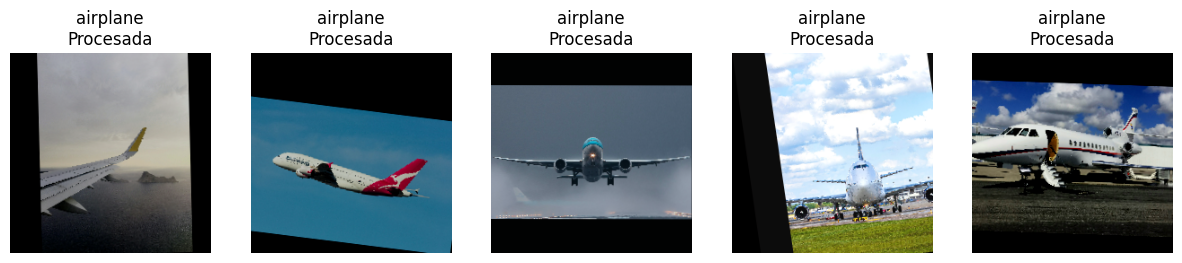

In [8]:
#Comprobamos que las imágenes con las que vamos a entrenar el modelo están bien preprocesadas

# Función para cargar los datos procesados o procesarlos si es la primera vez:
def obtener_datos_procesados(base_dir, subfolder):
    images_path = os.path.join(base_dir, f'{subfolder}_images.npy')
    labels_path = os.path.join(base_dir, f'{subfolder}_labels.npy')

    if os.path.exists(images_path) and os.path.exists(labels_path):
        print('Cargando imágenes preprocesadas')
        images = np.load(images_path)
        labels = np.load(labels_path)
    else:
        print(f'Preprocesando imágenes en {subfolder}')
        images, labels = preprocess_images(base_dir, subfolder)
    return images, labels

# Función para mostrar imágenes con Matplotlib
def mostrar_imagenes(procesadas, etiquetas, class_names, num_imagenes=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_imagenes):
        # Asegurarse de que las imágenes preprocesadas se normalicen adecuadamente
        plt.subplot(2, num_imagenes, i + 1 + num_imagenes)
        processed = procesadas[i]
        if processed.dtype != np.uint8:
            processed = np.clip(processed, 0, 1)
        plt.imshow(processed)
        
        index = etiquetas[i]
        if not isinstance(index, int):
            index = np.argmax(index)

        plt.title(f'{class_names[index]}\nProcesada')
        plt.axis('off')
    
    plt.show()

# Mostrar algunas imágenes preprocesadas de entrenamiento
num_imagenes_mostrar = 5
# Directorio base
base_dir = './imagenes'

# Usar la funcion compacta
train_images, train_labels = obtener_datos_procesados(base_dir, 'train')
val_images, val_labels = obtener_datos_procesados(base_dir, 'validation')

class_dir = os.path.join('./imagenes', 'validation')
class_names = os.listdir(class_dir)
mostrar_imagenes(val_images, val_labels, class_names, num_imagenes_mostrar)




In [9]:
# Para entrenar el modelo, damos los datos de partida:
directory = 'D:\\Desk'  
model_filename = '9_model.keras'
model_path = os.path.join(directory, model_filename) #Archivo donde se irá guardando el modelo entrenado.

# Creamos un df para almacenar los resultados de las iteraciones:
df = pd.DataFrame(columns=['training', 'final_accuracy', 'final_val_accuracy', 'final_loss', 'final_val_loss','lr'])
#Definimos el best_val_accuracy inicial como 0.
bva = 0.64


In [10]:
gc.collect()

10148

In [ ]:
#Ponemos el modelo a entrenar iterativamente

gc.collect()
if __name__ == "__main__":
    iteraciones = 1
    contador_bva = 0
    while iteraciones < 40: 
        if bva < 0.95:
            print(f"Iteración nº:{iteraciones}")
            df, nuevo_bva = entrenamiento2(model_path,9,df,bva)
            iteraciones +=1
            if nuevo_bva > bva:
                bva = nuevo_bva
                contador_bva = 0
            else:
                contador_bva+=1
                if contador_bva >=10:
                    # Si llegamos a diez iteraciones sin mejora en bva, volvemos a procesar las imágenes.
                    print("Valor de bva estancado, reprocesando imágenes")
                    train_images, train_labels = preprocess_images('./imagenes', 'train')
                    val_images, val_labels = preprocess_images('./imagenes', 'validation')
                    # Limpiamos tras el reprocesado de imágenes.
                    gc.collect()
                    contador_bva = 0
        else:
            break



In [ ]:
def mostrar_matriz_de_confusion(y_true, y_pred, class_names):
    y_pred = [pred_class if pred_class in class_names else "unknown" for pred_class in y_pred]
    unknown_class = "unknown"
    all_labels = class_names + [unknown_class]

    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    # Mostrar la matriz de confusión

    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
    disp.plot(cmap=plt.cm.Blues)

    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()
    return




1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
airplane_12.jpg: cup
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
airplane_15.jpg: book
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
airplane_16.jpg: basketball
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
airplane_18.jpg: book
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
airplane_19.jpg: book
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
airplane_29.jpg: basketball
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
airplane_9.jpg: book
En airplane ha habido 13/20 aciertos
1/1 ━━━━━━━━━━━━━━━━━━

<Figure size 1000x800 with 0 Axes>

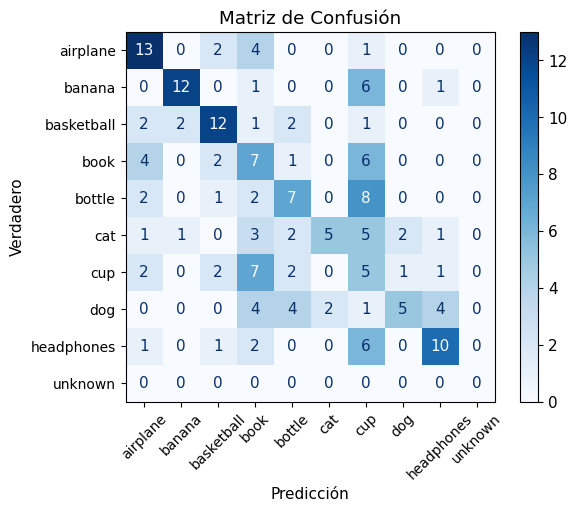

In [ ]:
# Probamos con el modelo KERAS

directory = 'D:\\Desk'  
model_filename = '9_model.keras'
model_path = os.path.join(directory, model_filename)
model = load_model(model_path)
class_names = ['airplane','banana', 'basketball', 'book','bottle','cat','cup', 'dog','headphones']


def obtener_predicciones(model, img_array, class_names):

    # Realiza la predicción
    prediction = model.predict(img_array)
    # Devuelve la clase con mayor probabilidad
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    predicted_class = class_names[predicted_class_idx]
    return predicted_class



# Itera sobre cada imagen en el directorio
image_dir = './imagenes/validation/'
accuracy = 0
conteo_imagenes = 0
y_true = []
y_pred = []
for clasecita in class_names:
    image_dir_class = os.path.join(image_dir, clasecita)
    recuento = 0
    totales = 0
    for image_file in os.listdir(image_dir_class):
        conteo_imagenes +=1
        if image_file.endswith(('.jpg', '.jpeg', '.png')):  # Comprueba que el archivo es una imagen
            image_path = os.path.join(image_dir_class, image_file)
            img = Image.open(image_path)
            img = img.resize((224, 224))
            img_array = np.array(img).astype('float32')
            img_array = np.expand_dims(img_array, axis=0)  # Agrega una dimensión más para el batch
            img_array /= 255.0  # Normaliza la imagen al rango [0, 1]
            predicted_class = obtener_predicciones(model, img_array, class_names)
            y_true.append(clasecita)
            y_pred.append(predicted_class)
            if predicted_class == clasecita:
                recuento += 1
                accuracy +=1
                totales +=1
            else:
                print(f"{image_file}: {predicted_class}")
                totales +=1
    print(f"En {clasecita} ha habido {recuento}/{totales} aciertos")
print(f'Accuracy: {accuracy}/{conteo_imagenes} = {accuracy/conteo_imagenes:.4f}')
mostrar_matriz_de_confusion(y_true, y_pred, class_names)


Using cache found in C:\Users\Usuario/.cache\torch\hub\ultralytics_yolov5_master


YOLOv5  2025-3-8 Python-3.12.9 torch-2.6.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


En airplane hay 20 imágenes y ha habido 20/20 aciertos
En banana hay 20 imágenes y ha habido 18/20 aciertos
En basketball hay 20 imágenes y ha habido 0/20 aciertos
En book hay 20 imágenes y ha habido 10/20 aciertos
En bottle hay 20 imágenes y ha habido 11/20 aciertos
En cat hay 20 imágenes y ha habido 20/20 aciertos
En cup hay 20 imágenes y ha habido 16/20 aciertos
En dog hay 20 imágenes y ha habido 18/20 aciertos
En headphones hay 20 imágenes y ha habido 0/20 aciertos
Accuracy: 113/180 = 0.6278


<Figure size 1000x800 with 0 Axes>

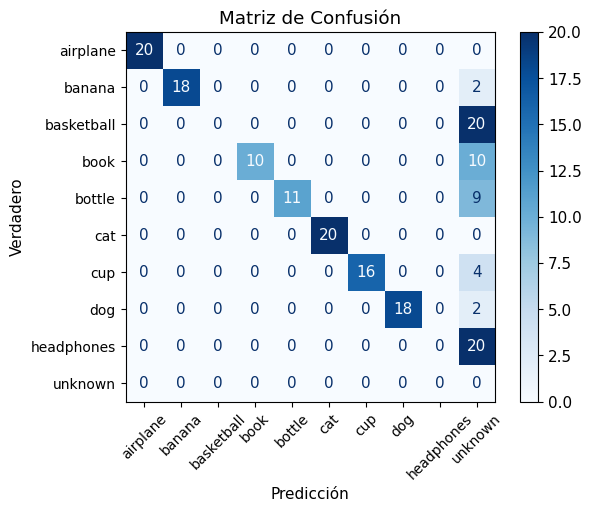

In [50]:
## Probando con el método de YOLO
import os
import cv2
import torch
import numpy as np
import easygui
import warnings

# Suprimir FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

image_dir = './imagenes/validation/'
if not image_dir:
    print("No image chosen.")
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.to('cpu')
model.eval()
class_names = ['airplane','banana', 'basketball', 'book','bottle','cat','cup', 'dog','headphones']
accuracy = 0
qty = 0
y_true = []
y_pred = []
for clasecita in class_names:
    image_dir_class = os.path.join(image_dir, clasecita)
    recuento = 0
    totales = 0
    conteo_imagen =0
    for image_file in os.listdir(image_dir_class):
        conteo_imagen +=1
        qty +=1
        if image_file.endswith(('.jpg', '.jpeg', '.png')):  # Comprueba que el archivo es una imagen
            image_path = os.path.join(image_dir_class, image_file)
            img = cv2.imread(image_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = model(img_rgb)
            detections = results.pandas().xyxy[0]
            encontrado = any(detections.name == clasecita)
            y_true.append(clasecita)
            if encontrado:
                y_pred.append(clasecita)
                recuento += 1
                totales += 1
                accuracy +=1
            else:
                y_pred.append('unknown')
                totales += 1
    print(f"En {clasecita} hay {conteo_imagen} imágenes y ha habido {recuento}/{totales} aciertos")  
print(f'Accuracy: {accuracy}/{qty} = {accuracy/qty:.4f}')
mostrar_matriz_de_confusion(y_true, y_pred, class_names)      
